In [1]:
%cd /NAS/mengyao/LETTER-master/data

/NAS/mengyao/LETTER-master/data


/home/mengyao/miniconda3/envs/mytry/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
from collections import defaultdict
dataset="Arts"

In [3]:
with open(f'{dataset}/{dataset}.item.json', 'r') as f:
    data = json.load(f)

In [ ]:
import json

def process_field(value):
    if not value or value.strip() == '.' or value.strip() == '':
        return 'na'
    return value.strip()

with open(f'./{dataset}/item_plain_text.txt', 'w') as f:
    for item_id, item_data in data.items():
        description = process_field(item_data.get('description', ''))
        categories = process_field(item_data.get('categories', ''))
        title = process_field(item_data.get('title', ''))
        brand = process_field(item_data.get('brand', ''))
        line = f"{item_id} description: {description}; categories: {categories}; title: {title}; brand: {brand}\n"
        f.write(line)

最短的 value: key='80', value=[''], 长度=1
最长的 value: key='13412', value=['Arts, Crafts & Sewing', 'Sewing', 'Sewing Notions & Supplies', 'Pins & Pincushions', 'Pins', 'Safety Pins', 'Package included:500PCS golden color metal calabash pins.', 'Size:Aprox 0.7*22mm', 'Material:made from high quality metal', 'durable and exquisite', 'Suitable for the Tailor', 'Good DIY Material.', 'Home neccessity', 'recommended by most housewives.'], 长度=14
[915, 1208, 5265, 8241, 4963, 293, 8, 26, 15, 14, 3, 2, 1, 2]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


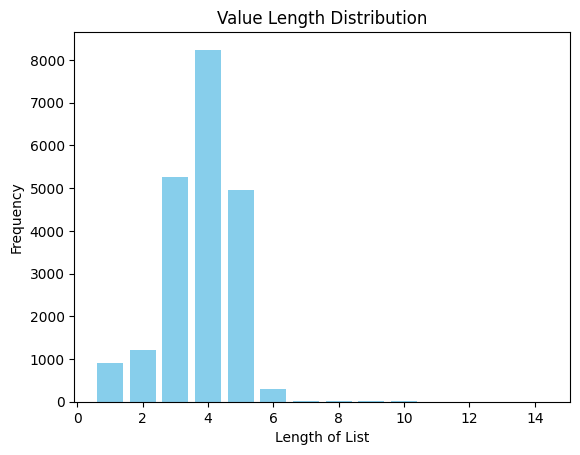

In [4]:
# 数据集统计分析 以选择category层次数
import re
from collections import Counter
import matplotlib.pyplot as plt
from collections import OrderedDict

def extract_categories(json_data):
    item_categories = {}
    for item_id, item_data in json_data.items():
        # categories = item_data['categories'].split(',')
        categories = re.split(r'(?<!\s),(?!\s)', item_data['categories'])
        categories = [cat.strip() for cat in categories] # 去重，保留最前面的
        categories = list(OrderedDict.fromkeys(categories))
        item_categories[item_id] = categories
    return item_categories
    
item_categories = extract_categories(data)

shortest_key, shortest_value = min(item_categories.items(), key=lambda item: len(item[1]))
shortest_length = len(shortest_value)

longest_key, longest_value = max(item_categories.items(), key=lambda item: len(item[1]))
longest_length = len(longest_value)
print(f"最短的 value: key='{shortest_key}', value={shortest_value}, 长度={shortest_length}")
print(f"最长的 value: key='{longest_key}', value={longest_value}, 长度={longest_length}")

lengths = [len(lst) for lst in item_categories.values()]
length_counts = Counter(lengths)

unique_lengths = sorted(length_counts.keys())
counts = [length_counts[length] for length in unique_lengths]
print(counts)
print(unique_lengths)

plt.bar(unique_lengths, counts, color='skyblue')
plt.title("Value Length Distribution")
plt.xlabel("Length of List")
plt.ylabel("Frequency")

plt.show()

with open(f'{dataset}/item_categories.json', 'w') as f:
    json.dump(item_categories, f, indent=2)

In [5]:
# 对类目编码category2codes
import numpy as np
import re
from collections import defaultdict
def get_hash(x):
    x = [str(_) for _ in x]
    return '_'.join(x)

pre_dict = {0:'first', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z'}
category_codes = {}
level2num = defaultdict(int)
for d,v in item_categories.items():
    for i in range(len(v)):
        if i==0:
            if v[i] not in category_codes:
                category_codes[v[i]] = [f"<{pre_dict[i]}:{level2num['first']}>"]
                level2num['first'] += 1
        else:
            if v[i] not in category_codes:
                pre_code = []
                pattern = r":(\d+)>"
                for s in category_codes[v[i-1]]:
                    match = re.search(pattern, s)
                    if match:
                        pre_code.append(int(match.group(1)))
                    else:
                        print("!!!")
                category_codes[v[i]] = category_codes[v[i-1]] + [f'<{pre_dict[i]}:{level2num[get_hash(pre_code)]}>']
                level2num[get_hash(pre_code)] += 1
# 去掉第一个 ''/'Musical Instruments'
category_codes = {k:v[1:] for k,v in category_codes.items()}
with open(f'{dataset}/category_codes.json', 'w') as f:
    json.dump(category_codes, f, indent=2)

In [6]:
# map item2category2codes
def convert_to_codes(item_categories, category_codes):
    item_category_codes = {}
    for item_id, categories in item_categories.items():
        codes = []
        for i in range(1,len(categories)):
            codes.append(category_codes[categories[i]])
        item_category_codes[item_id] = codes
    return item_category_codes

item_category_codes = convert_to_codes(item_categories, category_codes)
with open(f'{dataset}/item_category_codes.json', 'w') as f:
    json.dump(item_category_codes, f, indent=2)

In [7]:
# 选择阈值
with open(f'{dataset}/item_category_codes.json', 'r') as f:
    data = json.load(f)

level=3
count=0
num=0
for item, code in data.items():
    if len(code)<level:
        count += 1
    if len(code)>1:
        max_length = max(len(sublist) for sublist in code)
        if max_length<level:
            num+=1
print(count)
print(num)

7388
5248


In [8]:
with open(f'{dataset}/level2num.json', 'w') as f:
    json.dump(level2num, f, indent=2)

In [22]:
# 根据阈值截断/补全 item2code
with open(f'{dataset}/item_category_codes.json', 'r') as f:
    data = json.load(f)

def find_sublist(lst, level):
    for sublist in lst:
        if len(sublist) == level:
            return sublist
    
    max_length = max(len(sublist) for sublist in lst) if lst else 0
    
    for sublist in lst:
        if len(sublist) == max_length:
            return sublist
    return None

level=3
item2code = {}
for item, code in data.items():
    if len(code)==0:
        c = [f"<a:{level2num['0']}>"]
    else:
        c = find_sublist(code, level)
    if len(c) == level:
        item2code[item] = c
    elif len(c)>level:
        item2code[item] = c[:level]
    else:
        for i in range(len(c)+1, level+1):
            pre_code = [0]
            pattern = r":(\d+)>"
            for s in c:
                match = re.search(pattern, s)
                if match:
                    pre_code.append(int(match.group(1)))
                else:
                    print("!!!")
            c = c + [f'<{pre_dict[i]}:{level2num[get_hash(pre_code)]}>']
        item2code[item] = c
with open(f'{dataset}/{dataset}.category.json', 'w') as f:
    json.dump(item2code, f, indent=2)